<a href="https://colab.research.google.com/github/mukul-mschauhan/Data-Science-Projects/blob/master/Stacking%20on%20Boston%20Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
import warnings

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Function Approach to do the same
def _df(load):
  # Creating Dataframe
  df = pd.DataFrame(data = load.data, columns = load.feature_names)
  # Adding Output to the DF
  df["label"] = load.target
  # Return df
  return(df)

In [0]:
df = _df(load_boston()) # Running Function Created Above

In [12]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'label'],
      dtype='object')

In [16]:
# Data Dictionary
print(load_boston().DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [0]:
# Splitting the Data in Train and Test
from sklearn.model_selection import train_test_split

# Getting X and Ys
X = df.drop("label", axis = 1)
y = df.label

# Creating Train and Test
xtrain,xtest,ytrain,ytest = train_test_split(X, y, test_size = 0.33, random_state = None)

In [5]:
# Checking Sklearn Version
import sklearn
sklearn.__version__

'0.22.2.post1'

In [0]:
# Get a List of Models as Base Models
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor

from sklearn.linear_model import Ridge, Lasso
def base_models():
  models = dict()
  models['lr'] = LinearRegression()
  models["Ridge"] = Ridge()
  models["Lasso"] = Lasso()
  models["Tree"] = DecisionTreeRegressor()
  models["Random Forest"] = RandomForestRegressor()
  models["Bagging"] = BaggingRegressor()
  models["GBM"] = GradientBoostingRegressor()
  return models


In [0]:
# Now we will apply K Fold Cross Validation. We will now create a evaluate function with Repeated Stratified K Fold
# And Capture the Cross Val Score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, KFold, RepeatedKFold
from matplotlib import pyplot

# Function to evaluate the list of models
def eval_models(model):
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
  return scores

In [64]:
# Lets Apply and Calculate the Scores
# Getting X and Ys
X = df.drop("label", axis = 1)
y = df.label

# get the models to evaluate
models = base_models()
# evaluate the models and store results
results, names = list(), list() 

for name, model in models.items():
  scores = eval_models(model)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))


>lr 3.391 (0.530)
>Ridge 3.382 (0.519)
>Lasso 3.711 (0.549)
>Tree 2.875 (0.391)
>Random Forest 2.197 (0.353)
>Bagging 2.251 (0.343)
>GBM 2.088 (0.278)


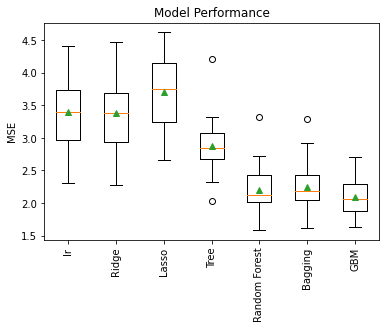

In [67]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation = 90)
pyplot.ylabel("MSE")
pyplot.title("Model Performance")
pyplot.show()

In [0]:
# get a stacking ensemble of models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
def get_stacking():
	# define the base models
  level0 = list()
  level0.append(('Tree', DecisionTreeRegressor()))
  level0.append(('RF', RandomForestRegressor()))
  level0.append(('XGB', XGBRegressor()))
  level0.append(('Bagging', BaggingRegressor()))
	# define meta learner model
  level1 = LGBMRegressor()
	# define the stacking ensemble
  model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
  return model

In [0]:
def base_models():
  models = dict()
  models["Tree"] = DecisionTreeRegressor()
  models["Random Forest"] = RandomForestRegressor()
  models["Bagging"] = BaggingRegressor()
  models["XGB"] = XGBRegressor()
  models["Stacked Model"] = get_stacking()
  return models

>Tree 2.924 (0.514)
>Random Forest 2.190 (0.370)
>Bagging 2.296 (0.358)
>XGB 2.146 (0.328)
>Stacked Model 2.708 (0.358)


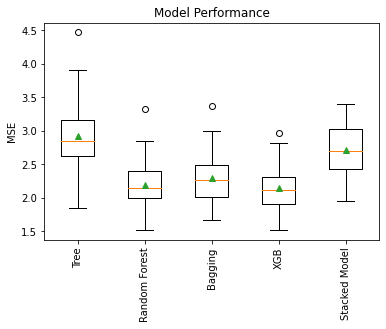

In [117]:
# Function to evaluate the list of models
def eval_models(model):
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
  return scores


# get the models to evaluate
models = base_models()
# evaluate the models and store results
results, names = list(), list() 

for name, model in models.items():
  scores = eval_models(model)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))


# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation = 90)
pyplot.ylabel("MSE")
pyplot.title("Model Performance")
pyplot.show()

In [0]:
# Lets apply on Train and Test Split
level0 = list()
level0.append(('Tree', DecisionTreeRegressor()))
level0.append(('RF', RandomForestRegressor()))
level0.append(('GBM', GradientBoostingRegressor()))
level0.append(('Bagging', BaggingRegressor()))
level0.append(("XGB", XGBRegressor()))

In [0]:
level1 = LGBMRegressor()
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=10)

In [122]:
# Making Predictions on Train & Test
stacked_pred = model.fit(xtrain, ytrain).predict(xtest)

[21:31:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [0]:
from sklearn.metrics import r2_score, mean_squared_error

In [123]:
# Checking Model Metrics
print(r2_score(ytest, stacked_pred))
print(np.sqrt(mean_squared_error(ytest, stacked_pred)))

0.8202170270477344
4.194178557256572


## Conclusion

Hence, it is clear that LightGBM is a better stacked model as it has increased the R2 Score to 0.82